# Introduction

This notebook provides a complete and reproducible overview of the geochemical data processing and visualization steps used to generate figures for the manuscript:

**Resilience of Deep Aquifer Microbial Communities to Seasonal Hydrological Fluctuations**  
*Sébastien Giroud¹, Longhui Deng, Mark A. Lever, Oliver S. Schilling, Rolf Kipfer*  
https://doi.org/10.1073/pnas.2422608122

---

## Background

This study investigates the influence of seasonal hydrological variability—particularly variations in precipitation, temperature, and shallow groundwater recharge—on fluid geochemistry and microbial communities in the deep geothermal system of Lavey-les-Bains, Switzerland. Our results reveal a pronounced decoupling: although deep groundwater exhibits clear seasonal signatures in conductivity and stable isotopic composition, microbial communities remain compositionally stable over time and are stratified with depth.

---

## Scope of This Notebook

This notebook focuses on the geochemical component of the analysis. It documents the workflow used to generate all figures related to:

- **Stable water isotopes** (δ²H, δ¹⁸O),
- **Methane isotopic composition**,
- **Major and trace ion geochemistry**, and
- **Helium isotopes and excess air indicators**.

It includes:

- **Data import and preprocessing** for stable isotopes, noble gases, and conductivity measurements,
- **Outlier detection and filtering** of chemical datasets,
- **Seasonal signal modeling** using sinusoidal fitting,
- **Correlation matrix generation** for depth-resolved hydrochemical data,
- **Custom plotting routines** for isotope mixing lines and groundwater endmember separation,
- **Export of high-resolution, publication-ready figures** using standardized output paths.

All input and output paths are modularly configured via `config.py` for portability, and sensitive or system-specific files are excluded via `.gitignore`.

---

## Related Notebook

A separate companion notebook is available for the analysis of high-frequency **partial pressure data** obtained with the miniRUEDI system. That notebook details the methods used for calibration, gas mixing interpretation, and temporal signal characterization of dissolved gases such as CO₂, O₂, and CH₄.

---

> **Note:** All datasets used in this notebook are either provided in the manuscript’s supplementary material or accessible through the cited literature.

## Environment Setup

This cell loads all required packages and sets plotting aesthetics and reproducibility controls. 
Ensure that the following libraries are installed in your environment.

In [10]:
# === Environment Setup ===

# --- Core Scientific Libraries ---
import numpy as np                           # Numerical computations
import pandas as pd                          # Data handling and manipulation
import matplotlib.pyplot as plt              # Plotting and visualization
from matplotlib.ticker import MultipleLocator, FixedLocator  # Custom tick placement

# --- Operating System Interface ---
import os                                    # Path and environment management

# --- Custom Modules ---
from src.functions import *                  # User-defined plotting/data functions
from src.config import FIGURES_DIR, DATA_DIR # Project-specific paths for output and data

# --- Reproducibility ---
import random
np.random.seed(42)                           # Fix NumPy RNG seed
random.seed(42)                              # Fix standard RNG seed

# --- Matplotlib Styling ---
plt.rcParams.update({
    "figure.dpi": 150,                       # On-screen resolution
    "savefig.dpi": 300,                      # Saved figure resolution
    "font.size": 12,                         # Base font size
    "axes.labelsize": 12,                    # Axis label font size
    "axes.titlesize": 14,                    # Title font size
    "legend.fontsize": 10,                   # Legend font size
    "xtick.labelsize": 10,                   # X-axis tick label size
    "ytick.labelsize": 10,                   # Y-axis tick label size
    "figure.figsize": (8, 5)                 # Default figure size
})
# Optional: Enable Seaborn styling
# sns.set_style("whitegrid")

# --- Jupyter/IPython Magic (Notebook-only) ---
# Ensure plots appear inline in notebooks
%matplotlib inline
# Enable interactive plots in VS Code

# --- Optional: Track package versions for reproducibility ---
# %load_ext watermark
# %watermark -v -p numpy,pandas,matplotlib,seaborn

## Methods

### Load the data

In [11]:
# === Load Data ===
# Adjust the path to your CSV file as needed. Here the file contains data for stables from Wallis (see references).
df_stables = pd.read_csv(DATA_DIR / 'stables_wallis.csv', sep=';')

### Geochemical Analysis

Figure saved to:
/Users/sebastiengiroud/Documents/ETH/PhD/vscode/article2/figures/stable_isotopes_plot.pdf


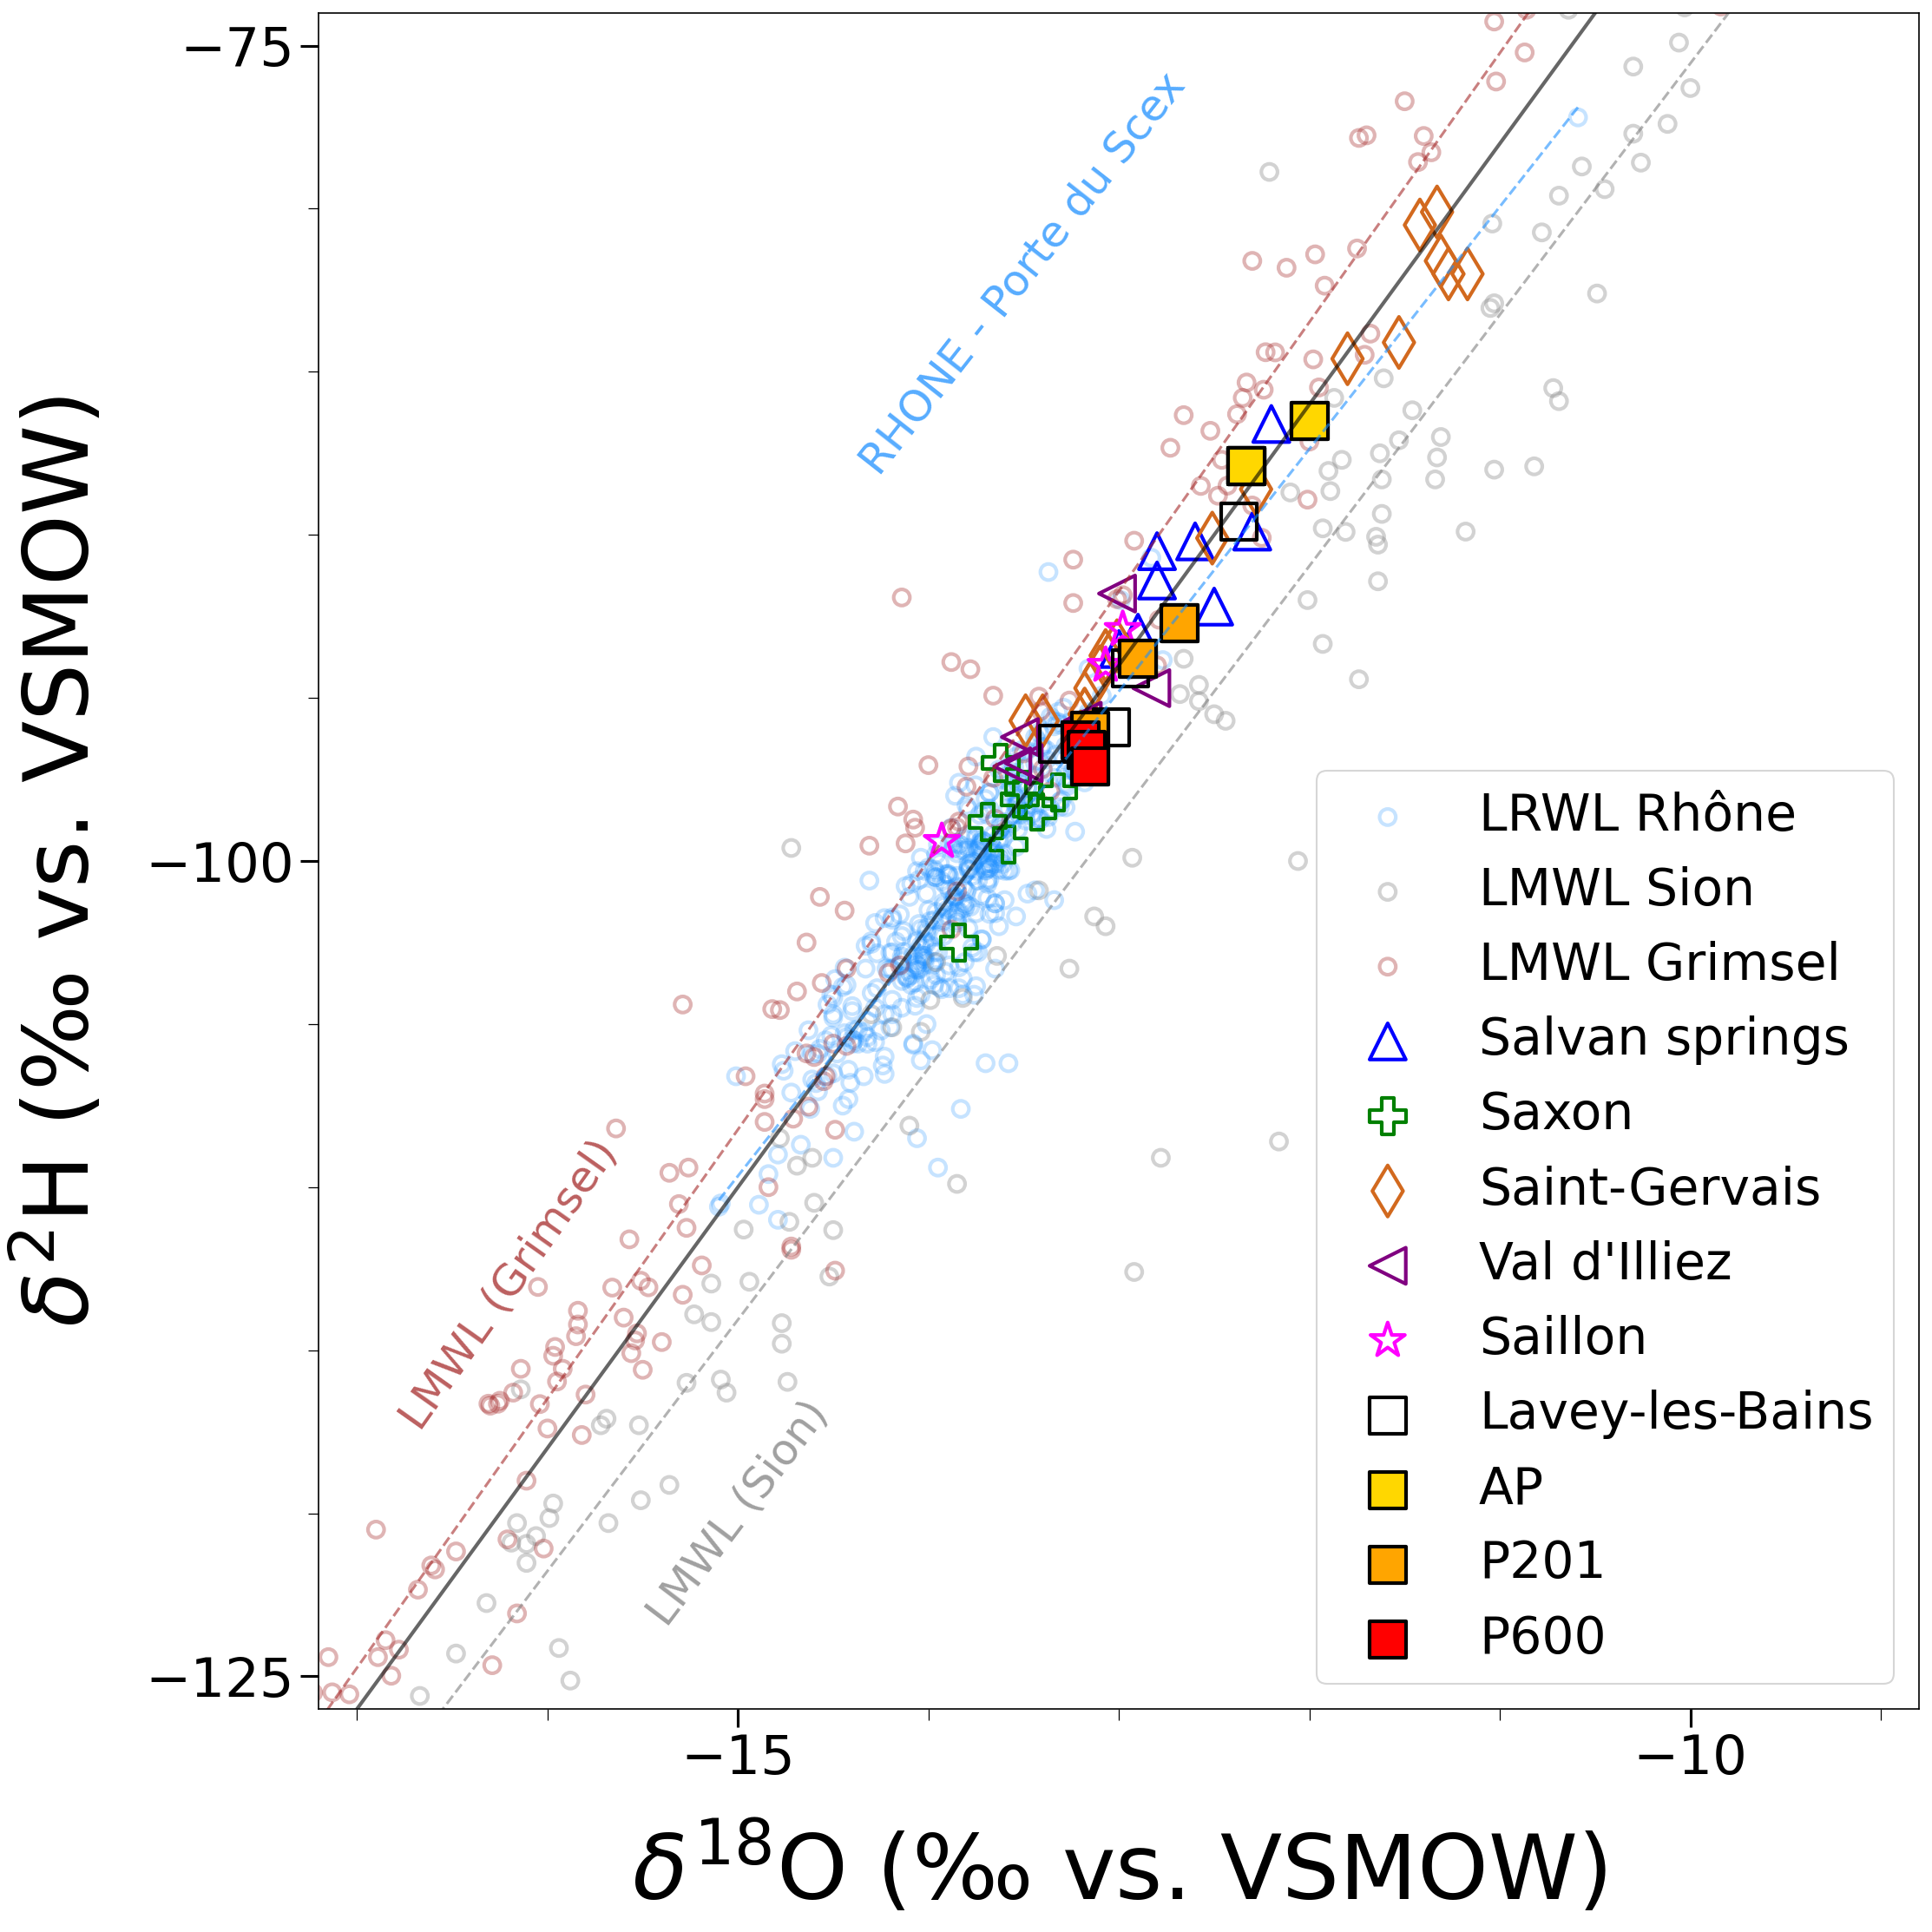

In [ ]:
# ============================================
# 1. Stable Isotopes Plotting
# ============================================

# === Define Output Path ===
PLOT_SAVE_PATH = FIGURES_DIR / 'stable_isotopes_plot.pdf'

# === Initialize Figure ===
fig, ax = plt.subplots(figsize=(15, 15))

# === Plot Reference Line: GMWL ===
plot_line_with_text(ax=ax, x_start=-20, x_end=0, slope=8, intercept=10, color='k', text='GMWL')

# === Define Site-Specific Plot Parameters ===
site_config = {
    'RHONE - Porte du Scex': {'color': 'dodgerblue', 'alpha': 0.25, 'marker': 'o', 'size': 80, 'label': 'LRWL Rhône'},
    'SION':                 {'color': 'gray',       'alpha': 0.35, 'marker': 'o', 'size': 80, 'label': 'LMWL Sion'},
    'GRIMSEL':              {'color': 'brown',      'alpha': 0.35, 'marker': 'o', 'size': 80, 'label': 'LMWL Grimsel'},
    'Salvan springs':       {'color': 'b',          'alpha': 1.00, 'marker': '^', 'size': 400,'label': 'Salvan springs'},
    'Saxon':                {'color': 'green',      'alpha': 1.00, 'marker': 'P', 'size': 400,'label': 'Saxon'},
    'Saint-Gervais':        {'color': 'chocolate',  'alpha': 1.00, 'marker': 'd', 'size': 400,'label': 'Saint-Gervais'},
    "Val d'Illiez":         {'color': 'purple',     'alpha': 1.00, 'marker': '<', 'size': 400,'label': "Val d'Illiez"},
    "Saillon":              {'color': 'magenta',    'alpha': 1.00, 'marker': '*', 'size': 400,'label': "Saillon"},
}

# === Plot Isotope Data by Site ===
for site, config in site_config.items():
    site_mask = df_stables['Site'] == site
    ax.scatter(df_stables['O18'][site_mask], 
               df_stables['H2'][site_mask],
               facecolors='none',
               edgecolors=config['color'],
               alpha=config['alpha'],
               marker=config['marker'],
               s=config['size'],
               linewidths=2,
               label=config['label'])

# === Highlight Lavey-les-Bains Sites ===
llb_mask = df_stables['Site'].isin(['Epinassey', 'Lavey-les-Bains'])
ax.scatter(df_stables['O18'][llb_mask],
           df_stables['H2'][llb_mask],
           facecolors='none', edgecolors='k',
           marker='s', s=400, linewidths=2, alpha=1,
           label='Lavey-les-Bains')

# === Highlight Lavey-les-Bains Comments ===
comment_colors = {'AP': 'gold', 'P201': 'orange', 'P600': 'red'}
llb_data = df_stables[df_stables['Site'] == 'Lavey-les-Bains']
for comment, color in comment_colors.items():
    subset = llb_data[llb_data['Comment'] == comment]
    ax.scatter(subset['O18'], subset['H2'],
               facecolors=color, edgecolors='k',
               marker='s', s=400, linewidths=2,
               alpha=1, label=comment)

# === Plot Local Meteoric Water Line Fits ===
plot_linear_fit_with_text_on_line(ax=ax,
    x=df_stables['O18'][df_stables['Site'] == 'SION'],
    y=df_stables['H2'][df_stables['Site'] == 'SION'],
    color='gray', text='LMWL (Sion)', x_text=-15, y_text=-120)

plot_linear_fit_with_text_on_line(ax,
    x=df_stables['O18'][df_stables['Site'] == 'GRIMSEL'],
    y=df_stables['H2'][df_stables['Site'] == 'GRIMSEL'],
    color='brown', text='LMWL (Grimsel)', x_text=-16.2, y_text=-113)

plot_linear_fit_with_text_on_line(ax,
    x=df_stables['O18'][df_stables['Site'] == 'RHONE - Porte du Scex'],
    y=df_stables['H2'][df_stables['Site'] == 'RHONE - Porte du Scex'],
    color='dodgerblue', text='RHONE - Porte du Scex', x_text=-13.5, y_text=-82)

# === Axis Configuration ===
ax.set_xlim(-17.2, -8.8)
ax.set_ylim(-126, -74)

ax.set_xlabel(r'$\delta^{18}$O (‰ vs. VSMOW)', fontsize=50, labelpad=20)
ax.set_ylabel(r'$\delta^2$H (‰ vs. VSMOW)', fontsize=50, labelpad=20)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

# === Tick Placement ===
ax.xaxis.set_major_locator(FixedLocator([-10, -15]))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(FixedLocator([-75, -100, -125]))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(axis='both', which='major', length=10, width=1.5)
ax.tick_params(axis='both', which='minor', length=6, labelleft=False)

# === Final Touches ===
ax.legend(loc='best', fontsize=28)
plt.tight_layout()

# === Save Figure ===
plt.savefig(PLOT_SAVE_PATH, bbox_inches='tight')
print(f"Figure saved to:\n{PLOT_SAVE_PATH}")


/var/folders/y2/y3bfkw4554n11f2m_86r6x9w0000gn/T/ipykernel_37489/2514033351.py:71: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


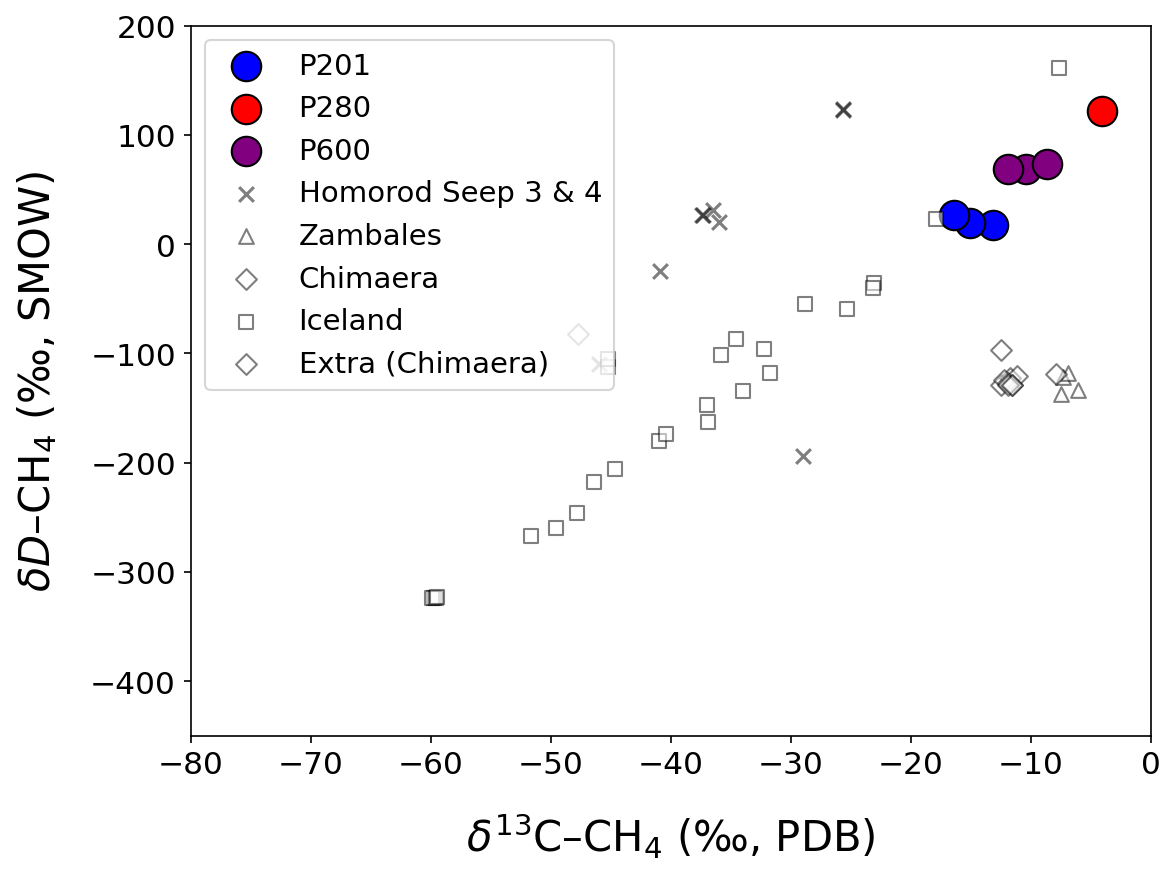

Figure saved to: /Users/sebastiengiroud/Documents/ETH/PhD/vscode/article2/figures/isotopes_CH4_full.pdf


In [ ]:
# ============================================
# 2. CH₄ Isotopes Plotting
# ============================================

# === Save Path ===
PLOT_SAVE_PATH = FIGURES_DIR / 'isotopes_CH4_full.pdf'

# === Original Groundwater CH₄ Isotope Data ===
group_data = {
    "P201": {
        "points": [(17, -13.2), (19, -15.1), (27, -16.4)],
        "color": "blue"
    },
    "P280": {
        "points": [(122, -4.1)],
        "color": "red"
    },
    "P600": {
        "points": [(69, -10.4), (73, -8.7), (69, -11.9)],
        "color": "purple"
    },
}

# === External Reference Datasets (see cited papers) ===
external_sources = {
    "Homorod Seep 3 & 4": {
        "δD": [124, 123, 31.0, -25.0, 27.0, 27.0, 20.0, -110, -193.6],
        "δ13C": [-25.66, -25.70, -36.49, -40.89, -37.40, -37.30, -36.02, -45.96, -29.00],
        "color": "black", "marker": "x"
    },
    "Zambales": {
        "δD": [-122, -137, -118, -134],
        "δ13C": [-7.34, -7.50, -6.93, -6.11],
        "color": "white", "marker": "^"
    },
    "Chimaera": {
        "δD": [-129.0, -119.1, -122.5, -124.1, -120.6, -127.2, -128.9, -96.7, -129.2, -129.4],
        "δ13C": [-12.51, -7.88, -11.74, -12.27, -11.14, -11.9, -11.6, -12.5, -11.9, -11.6],
        "color": "white", "marker": "D"
    },
    "Iceland": {
        "δD": [
            22.9, -95.9, -147.6, -205.9, -218.2, -35.8, -101.7, -134.2, -118.0,
            -246.4, -260.3, -59.2, -39.8, -267.2, -54.7, 161.1, -179.8, -86.6, -162.8, -174.1,
            -324.3, -324.1, -323.6, -322.6, -112.6, -104.9
        ],
        "δ13C": [
            -17.93, -32.27, -37.02, -44.67, -46.38, -23.04, -35.82, -34.00, -31.74, -47.84,
            -49.57, -25.31, -23.17, -51.61, -28.81, -7.63, -40.97, -34.57, -36.90, -40.4,
            -59.71, -59.89, -59.54, -59.51, -45.24, -45.23
        ],
        "color": "white", "marker": "s"
    },
    "Extra (Chimaera)": {
        "δD": [-82.6],
        "δ13C": [-47.7],
        "color": "white", "marker": "D"
    }
}

# === Create Plot ===
fig, ax = plt.subplots(figsize=(8, 6))

# Plot groundwater sample groups
for label, data in group_data.items():
    δD_vals, δ13C_vals = zip(*data["points"])
    ax.scatter(
        δ13C_vals, δD_vals,
        color=data["color"], edgecolors='black',
        s=200, label=label
    )

# Plot external datasets
for label, dataset in external_sources.items():
    ax.scatter(
        dataset["δ13C"], dataset["δD"],
        color=dataset["color"], edgecolors='black',
        alpha=0.5, s=50, marker=dataset["marker"],
        label=label
    )

# === Axis Configuration ===
ax.set_xlabel(r'$\delta^{13}$C–CH$_4$ (‰, PDB)', fontsize=20, labelpad=15)
ax.set_ylabel(r'$\delta D$–CH$_4$ (‰, SMOW)', fontsize=20, labelpad=15)
ax.set_xlim(-80, 0)
ax.set_ylim(-450, 200)
ax.tick_params(labelsize=15)
#ax.grid(True, linestyle='--', alpha=0.5)

# === Legend & Export ===
ax.legend(loc='upper left', fontsize=14)
plt.tight_layout()
plt.savefig(PLOT_SAVE_PATH, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {PLOT_SAVE_PATH}")

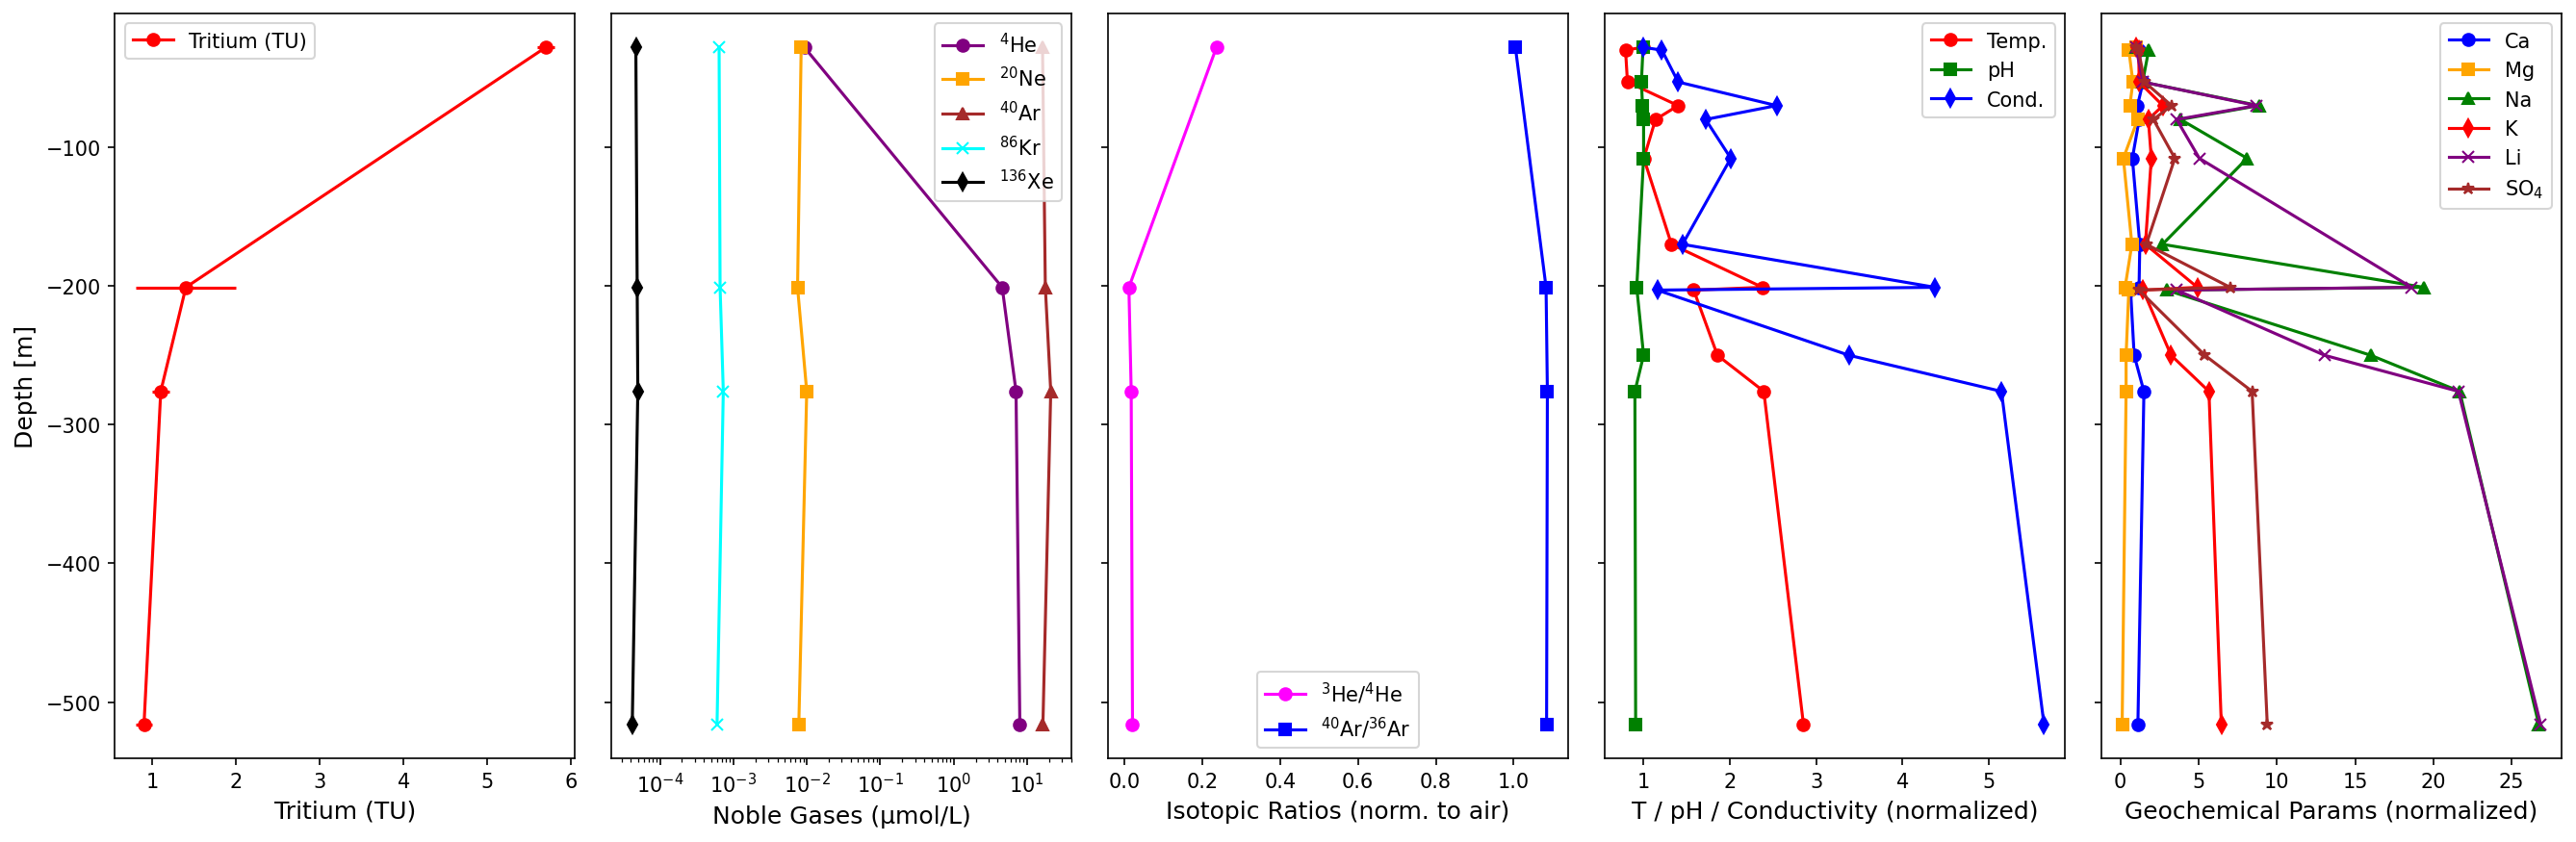

Figure saved to: /Users/sebastiengiroud/Documents/ETH/PhD/vscode/article2/figures/geochemistry_full_plot.pdf


In [ ]:
# ============================================
# 3. Geochemistry Full Plotting
# ============================================

# === Save Path ===
PLOT_SAVE_PATH = FIGURES_DIR / "geochemistry_full_plot.pdf"

# === Depths and TU ===
depths_gas = np.array([-28, -201, -276, -516])
tritium = np.array([5.7, 1.4, 1.1, 0.9])
tritium_err = np.array([0.1, 0.6, 0.1, 0.1])

# === Noble Gases (μmol/L) ===
He4   = np.array([9.3e-3, 4.6, 7.1, 8.0])
Ne20  = np.array([8.4e-3, 7.5e-3, 1.0e-2, 7.8e-3])
Ar40  = np.array([16.3, 17.8, 21.1, 16.5])
Kr86  = np.array([6.4e-4, 6.6e-4, 7.3e-4, 6.0e-4])
Xe136 = np.array([4.7e-5, 4.9e-5, 5.0e-5, 4.2e-5])

# === Isotopic Ratios ===
He3_He4     = np.array([3.3e-7, 1.5e-8, 2.33e-8, 2.8e-8])
He3_He4_err = np.array([0.1e-7, 0.6e-8, 2e-8, 0.2e-8])
He3_He4_atm = 1.399e-6

Ar40_Ar36     = np.array([296.9, 320.2, 321.2, 320.6])
Ar40_Ar36_err = np.array([0.3, 0.3, 0.3, 0.3])
Ar40_Ar36_atm = 295.5

# === Physical/Chemical Parameters ===
wells = ['AP', 'P11', 'S7', 'S9', 'S8', 'P14', 'P12', 'P201', 'P13', 'P205', 'P280', 'P600']
depths = np.array([-28.0, -30.0, -53.0, -70.0, -80.0, -108.0, -170.0, -201.0, -203.0, -250.0, -276.0, -516.0])
temperature = np.array([22.2, 17.7, 18.2, 31.2, 25.4, 22.4, 29.5, 52.85, 35.2, 41.3, 53.2, 63.375])
conductivity = np.array([340.0, 414.0, 478.0, 865.0, 586.0, 685.0, 495.0, 1488.25, 396.0, 1150.0, 1749.0, 1916.33])
pH = np.array([7.95, np.nan, 7.8, 7.9, 8.0, 8.0, np.nan, 7.37, np.nan, 8.0, 7.2, 7.27])
filtered_pH, filtered_depths = filter_nan(pH, depths)

# === Geochemistry Parameters ===
Ca  = np.array([1.22, 1.42, 1.77, 1.34, 1.47, 0.94, 1.52, 1.46, 0.80, 1.08, 1.84, 1.37])
Mg  = np.array([0.46, 0.25, 0.37, 0.28, 0.51, 0.09, 0.34, 0.14, 0.25, 0.17, 0.17, 0.054])
Na  = np.array([0.59, 1.07, 0.84, 5.22, 2.27, 4.78, 1.59, 11.44, 1.74, 9.44, 12.79, 15.77])
K   = np.array([0.053, 0.062, 0.064, 0.144, 0.095, 0.105, 0.085, 0.261, 0.077, 0.172, 0.3, 0.342])
Li  = np.array([0.020, np.nan, 0.029, 0.174, 0.072, 0.101, np.nan, 0.372, 0.072, 0.261, 0.432, 0.537])
SO4 = np.array([0.62, 0.72, 0.96, 2.03, 1.31, 2.16, 1.03, 4.35, 0.74, 3.35, 5.22, 5.82])
geochemistry = [Ca, Mg, Na, K, Li, SO4]
geochem_labels = ["Ca", "Mg", "Na", "K", "Li", "SO$_4$"]
geochem_symbols = ['o-', 's-', '^-', 'd-', 'x-', '*-']
geochem_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# === Plot Layout ===
fig, axs = plt.subplots(1, 5, figsize=(18, 6), sharey=True)

# === Plot 1: Tritium ===
axs[0].errorbar(tritium, depths_gas, xerr=tritium_err, fmt='o-', color="red", label="Tritium (TU)")
axs[0].set_xlabel("Tritium (TU)")
axs[0].set_ylabel("Depth [m]")
axs[0].legend()
#axs[0].grid(True)

# === Plot 2: Noble Gases ===
ax = axs[1]
ax.plot(He4, depths_gas, 'o-', label="$^4$He", color="purple")
ax.plot(Ne20, depths_gas, 's-', label="$^{20}$Ne", color="orange")
ax.plot(Ar40, depths_gas, '^-', label="$^{40}$Ar", color="brown")
ax.plot(Kr86, depths_gas, 'x-', label="$^{86}$Kr", color="cyan")
ax.plot(Xe136, depths_gas, 'd-', label="$^{136}$Xe", color="black")
ax.set_xlabel("Noble Gases (μmol/L)")
ax.set_xscale("log")
ax.legend()
#ax.grid(True)

# === Plot 3: Isotopic Ratios ===
axs[2].plot(He3_He4 / He3_He4_atm, depths_gas, 'o-', color="magenta", label="$^3$He/$^4$He")
axs[2].plot(Ar40_Ar36 / Ar40_Ar36_atm, depths_gas, 's-', color="blue", label="$^{40}$Ar/$^{36}$Ar")
axs[2].set_xlabel("Isotopic Ratios (norm. to air)")
axs[2].legend()
#axs[2].grid(True)

# === Plot 4: T/pH/Cond (Normalized to AP) ===
axs[3].plot(temperature / temperature[0], depths, 'o-', label="Temp.", color="red")
axs[3].plot(filtered_pH / filtered_pH[0], filtered_depths, 's-', label="pH", color="green")
axs[3].plot(conductivity / conductivity[0], depths, 'd-', label="Cond.", color="blue")
axs[3].set_xlabel("T / pH / Conductivity (normalized)")
axs[3].legend()
#axs[3].grid(True)

# === Plot 5: Geochemistry (Normalized) ===
for data, label, style, color in zip(geochemistry, geochem_labels, geochem_symbols, geochem_colors):
    filtered_vals, filtered_depths = filter_nan(data, depths)
    axs[4].plot(filtered_vals / filtered_vals[0], filtered_depths, style, label=label, color=color)

axs[4].set_xlabel("Geochemical Params (normalized)")
axs[4].legend()
#axs[4].grid(True)

# === Export Plot ===
plt.tight_layout()
plt.savefig(PLOT_SAVE_PATH, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {PLOT_SAVE_PATH}")

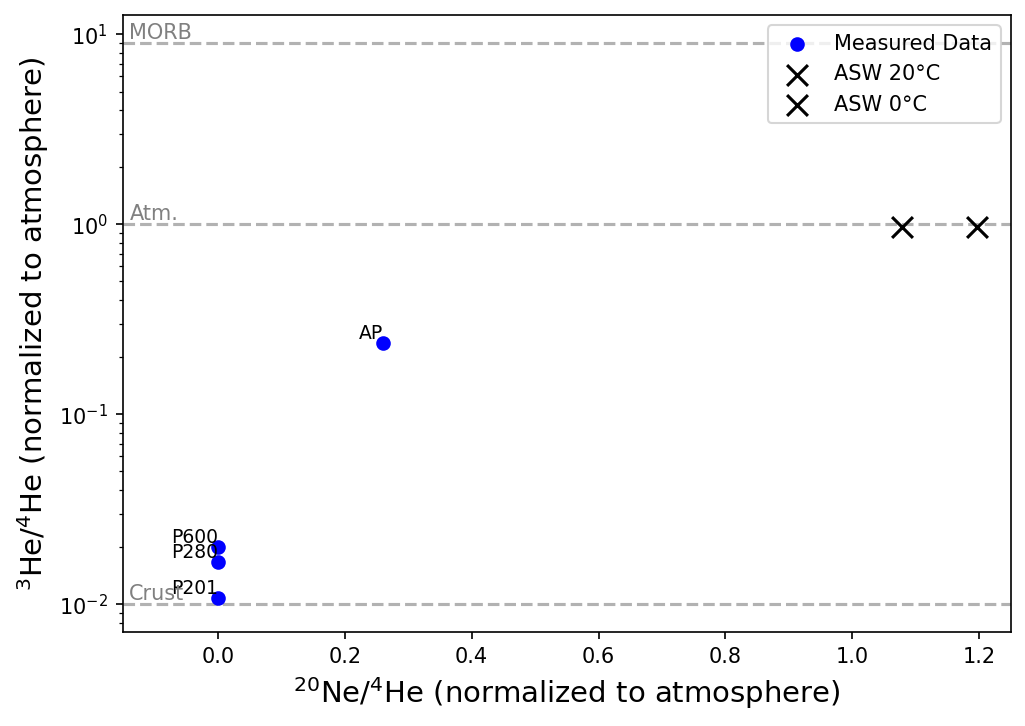

Figure saved to: /Users/sebastiengiroud/Documents/ETH/PhD/vscode/article2/figures/Ne20-He3-He4.pdf


In [ ]:
# ============================================
# 4. Ne20-He3-He4 Plotting
# ============================================

# === Save Path ===
PLOT_SAVE_PATH = FIGURES_DIR / "Ne20-He3-He4.pdf"

# === Atmospheric and ASW References ===
R_Ne20_He4_atm = 1.818e-5 / 5.24e-6     # Atmospheric ²⁰Ne/⁴He
R_He3_He4_atm  = 1.399e-6               # Atmospheric ³He/⁴He

Ne20_He4_ASW_20 = 4.1518                # ASW ²⁰Ne/⁴He @ 20°C
Ne20_He4_ASW_0  = 3.7421                # ASW ²⁰Ne/⁴He @ 0°C
He3_He4_ASW_20  = 1.3614e-06            # ASW ³He/⁴He @ 20°C
He3_He4_ASW_0   = 1.3590e-06            # ASW ³He/⁴He @ 0°C

# === Endmember Values ===
He3_He4_rad    = 0.01 * R_He3_He4_atm
He3_He4_MORB   = 9 * R_He3_He4_atm

# === Labels ===
labels     = ["AP", "P201", "P280", "P600"]  # Sample labels
labels_em  = ["Atm.", "Crust", "MORB"]       # Endmember labels
endmembers_y = [R_He3_He4_atm, He3_He4_rad, He3_He4_MORB]

# === Compute Measured Ratio (normalized to atmospheric) ===
Ne20_He4_ratio = Ne20 / He4
Ne20_He4_norm = Ne20_He4_ratio / R_Ne20_He4_atm
He3_He4_norm = He3_He4 / R_He3_He4_atm

# === Plot ===
fig, ax = plt.subplots(figsize=(7, 5))

# Plot measured data
ax.scatter(Ne20_He4_norm, He3_He4_norm, color='blue', label='Measured Data', zorder=3)

# Optionally annotate sample points
for i, label in enumerate(labels):
    ax.text(Ne20_He4_norm[i], He3_He4_norm[i], label,
            fontsize=9, ha='right', va='bottom', color='black')

# Plot ASW references
ax.scatter(Ne20_He4_ASW_20 / R_Ne20_He4_atm, He3_He4_ASW_20 / R_He3_He4_atm,
           color='black', marker='x', s=100, label="ASW 20°C", zorder=4)
ax.scatter(Ne20_He4_ASW_0 / R_Ne20_He4_atm, He3_He4_ASW_0 / R_He3_He4_atm,
           color='black', marker='x', s=100, label="ASW 0°C", zorder=4)

# Plot horizontal lines for endmembers
for label, y_val in zip(labels_em, endmembers_y):
    ax.axhline(y=y_val / R_He3_He4_atm, linestyle='--', color='gray', alpha=0.6)
    ax.text(ax.get_xlim()[0] - 0.08, y_val / R_He3_He4_atm, label,
            fontsize=10, va='bottom', ha='left', color='gray')

# === Axes and Styling ===
ax.set_xlabel(r"$^{20}$Ne/$^4$He (normalized to atmosphere)", fontsize=14)
ax.set_ylabel(r"$^3$He/$^4$He (normalized to atmosphere)", fontsize=14)
ax.set_yscale("log")
ax.set_xlim(-0.15, 1.25)
#ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper right', fontsize=10)

# === Save and Display ===
plt.tight_layout()
plt.savefig(PLOT_SAVE_PATH, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {PLOT_SAVE_PATH}")